<i>Updated 19/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />


# AutoEncoder Training for MNIST dataset with Tensorflow 2 on Google Colab
## MNISTデータセットに対して AutoEncoder を Google Colab 上で Tensorflow 2 で訓練する

In [ ]:
#! pip install tensorflow==2.7.0

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# AutoEncoder

<ul>
<li>
Diederik P Kngma, Max Welling: Auto-Encoding Variational Bayes, 2013<br />
<a href="https://arxiv.org/abs/1312.6114">https://arxiv.org/abs/1312.6114</a>
</li>
<p>
「難しい事後分布を持つ連続潜在変数が存在し、さらにデータセットが大きい場合に、有効確率モデルを用いて効果的な推論と学習をどうやって行えばよいのだろうか」という問題がある。
この論文では、ある穏やかな(mild)微分可能条件下では適用できる、確率的変分推論と学習アルゴリズムを紹介する。
貢献する点は2点である。
「変分下限の再パラメータ化により、普通のSGDを用いてtraining可能な下限推定量が得られる」
「提案する下限推定器を用いて近似推論モデルを学習することによって、データポイント毎の連続潜在変数を持つ i.i.d データセットに対して事後推定が効率的に実行できる。」
</p>
</ul>

# Check the execution environment on Google Colab
## Google Colab 上の実行環境を確認する

In [ ]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Mon Nov 22 06:21:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab
## Google Colab から GoogleDrive をマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls /content/drive

MyDrive  Shareddrives


# Download the soure file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive. Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

## Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に Google Drive から <code>gdown</code> してください。 Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [ ]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True: # from Google Drive
    url_model = 'https://drive.google.com/uc?id=1ZDgWE7wmVwG_ZuQVUjuh_XHeIO-7Yn63'
    ! (cd {nw_path}; gdown {url_model})
else:    # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/AutoEncoder.py'
    ! wget -nd {url_model} -P {nw_path}     # download to './nw/AutoEncoder.py'

Downloading...
From: https://drive.google.com/uc?id=1ZDgWE7wmVwG_ZuQVUjuh_XHeIO-7Yn63
To: /content/nw/AutoEncoder.py
100% 13.9k/13.9k [00:00<00:00, 21.5MB/s]


In [ ]:
!cat {nw_path}/AutoEncoder.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import datetime

class AutoEncoder():
    def __init__(self, 
                 input_dim,
                 encoder_conv_filters,
                 encoder_conv_kernel_size,
                 encoder_conv_strides,
                 decoder_conv_t_filters,
                 decoder_conv_t_kernel_size,
                 decoder_conv_t_strides,
                 z_dim,
                 use_batch_norm = False,
                 use_dropout = False,
                 epoch = 0
    ):
        self.name = 'autoencoder'
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_c

# Preparing the MNIST datasets
## MNIST データセットを用意する

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
# MNIST datasets
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test_raw.shape)
print(y_test_raw.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
x_train = x_train_raw.reshape(x_train_raw.shape+(1,)).astype('float32') / 255.0
x_test = x_test_raw.reshape(x_test_raw.shape+(1,)).astype('float32') / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Define the Neural Network Model

Use the <code>AutoEncoder</code> class downloaded from nw.tsuda.ac.jp.

## ニューラルネットワーク・モデル の定義

nw.tsuda.ac.jp からダウンロードした <code>AutoEncoder</code> クラスを使う。

In [ ]:
from nw.AutoEncoder import AutoEncoder

AE = AutoEncoder(
    input_dim = (28, 28, 1),
    encoder_conv_filters = [32, 64, 64, 64],
    encoder_conv_kernel_size = [3, 3, 3, 3],
    encoder_conv_strides = [1, 2, 2, 1],
    decoder_conv_t_filters = [64, 64, 32, 1],
    decoder_conv_t_kernel_size = [3, 3, 3, 3],
    decoder_conv_t_strides = [1, 2, 2, 1],
    z_dim = 2
)

In [ ]:
AE.encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0     

In [ ]:
AE.decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                   

# Training the Neural Model


Try the training in 3 ways.



With each way, you first train a few times and save the state to some files.
Then, after loading the saved states, further training proceeds.

## ニューラルモデルを学習する

3通りの方法で学習を試みる。
どの方法においても、まず数回学習を進めて、状態をファイルに保存する。
そして、保存した状態をロードしてから、さらに学習を進める。

In [ ]:
MAX_EPOCHS = 200

In [ ]:
learning_rate = 0.0005

# (1) Simple Training with fit()


Instead of using callbacks, simply train using fit() function.

## (1) fit() 関数を使った単純なTraining

callbackは使わずに、単純にfit()を使ってtrainingしてみる。

In [ ]:
save_path1 = '/content/drive/MyDrive/ColabRun/AE01'

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
AE.model.compile(optimizer=optimizer, loss=AutoEncoder.r_loss)

In [ ]:
# At first, train for a few epochs.
# まず、少ない回数 training してみる

history=AE.train_with_fit(
    x_train,
    x_train,
    batch_size=32,
    epochs = 3,
    run_folder = save_path1,
    validation_data = (x_test, x_test)
)

Epoch 1/3
1875/1875 [==============================] - 27s 6ms/step - loss: 0.0550 - val_loss: 0.0487
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0464 - val_loss: 0.0449
Epoch 3/3
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0444 - val_loss: 0.0439


In [ ]:
print(history.history)

{'loss': [0.05495461821556091, 0.0464060977101326, 0.04438251256942749], 'val_loss': [0.04873434454202652, 0.04490825906395912, 0.043926868587732315]}


In [ ]:
# Load the trained states saved before
# 保存されている学習結果をロードする

AE_work = AutoEncoder.load(save_path1)

# display the epoch count of training
# training のepoch回数を表示する
print(AE_work.epoch)

3


In [ ]:
# Then, train for more epochs. The training continues from the current self.epoch to the epoches specified.
# 追加でtrainingする。保存されている現在のepoch数から始めて、指定したepochs までtrainingが進む。

AE_work.model.compile(optimizer, loss=AutoEncoder.r_loss)

history_work = AE_work.train_with_fit(
    x_train,
    x_train,
    batch_size=32,
    epochs=MAX_EPOCHS,
    run_folder = save_path1,
    validation_data=(x_test, x_test)
)

Epoch 4/200
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0439 - val_loss: 0.0428
Epoch 5/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0422 - val_loss: 0.0421
Epoch 6/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0417 - val_loss: 0.0414
Epoch 7/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0412 - val_loss: 0.0412
Epoch 8/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0409 - val_loss: 0.0409
Epoch 9/200
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0406 - val_loss: 0.0411
Epoch 10/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0404 - val_loss: 0.0405
Epoch 11/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0402 - val_loss: 0.0403
Epoch 12/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0401 - val_loss: 0.0402
Epoch 13/200
1875/1875 [==============================] - 10s

In [ ]:
# the return value contains the loss values in the additional training. 
# 追加で行ったtraining時のlossが返り値に含まれる
print(len(history_work.history['loss']))

197


In [ ]:
loss1_1 = history.history['loss']
vloss1_1 = history.history['val_loss']

loss1_2 = history_work.history['loss']
vloss1_2 = history_work.history['val_loss']

loss1 = np.concatenate([loss1_1, loss1_2], axis=0)
val_loss1 = np.concatenate([vloss1_1, vloss1_2], axis=0)

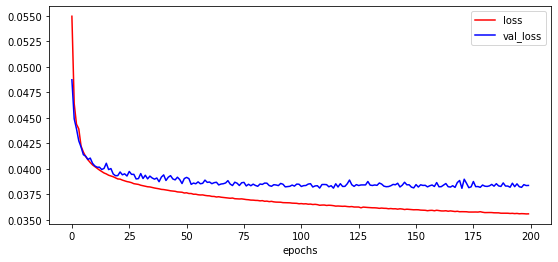

In [ ]:
AutoEncoder.plot_history([loss1, val_loss1], ['loss', 'val_loss'])

# Validate the training results.
## Training 結果を検証する

In [ ]:
selected_indices = np.random.choice(range(len(x_test)), 10)
selected_images = x_test[selected_indices]

In [ ]:
z_points = AE_work.encoder.predict(selected_images)
reconst_images = AE_work.decoder.predict(z_points)

txts = [ f'{p[0]:.3f}, {p[1]:.3f}' for p in z_points ]

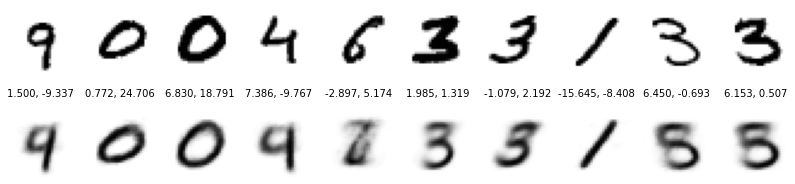

In [ ]:
%matplotlib inline

AutoEncoder.showImages(selected_images, reconst_images, txts, 1.4, 1.4)

# (2) Training with <code>tf.GradientTape()</code> function.


Instead of using <code>fit()</code>, calculate the loss in  your own <code>train()</code> function, find the gradients, and apply them to the variables.

The <code>train_tf()</code> function is speeding up by declaring <code>@tf.function</code> the <code>compute_loss_and_grads()</code> function.


## (2) <code>tf.GradientTape()</code> 関数を使った学習


<code>fit()</code> 関数を使わずに、自分で記述した <code>train()</code> 関数内で loss を計算し、gradients を求めて、変数に適用する。

<code>train_tf()</code> 関数では、lossとgradientsの計算を行う <code>compute_loss_and_grads()</code> 関数を <code>@tf.function</code> 宣言することで高速化を図っている。


In [ ]:
save_path2 = '/content/drive/MyDrive/ColabRun/AE02/'

In [ ]:
from nw.AutoEncoder import AutoEncoder

AE2 = AutoEncoder(
    input_dim = (28, 28, 1),
    encoder_conv_filters = [32, 64, 64, 64],
    encoder_conv_kernel_size = [3, 3, 3, 3],
    encoder_conv_strides = [1, 2, 2, 1],
    decoder_conv_t_filters = [64, 64, 32, 1],
    decoder_conv_t_kernel_size = [3, 3, 3, 3],
    decoder_conv_t_strides = [1, 2, 2, 1],
    z_dim = 2
)

In [ ]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# At first, train for a few epochs.
# まず、少ない回数 training してみる

loss2_1, vloss2_1 = AE2.train(
    x_train,
    x_train,
    batch_size=32,
    epochs = 3, 
    shuffle=True,
    run_folder= save_path2,
    optimizer = optimizer2,
    save_epoch_interval=50,
    validation_data=(x_test, x_test)
    )

1/3 1875 loss: 0.0406  val loss: 0.0481  0:00:39.580740
2/3 1875 loss: 0.0391  val loss: 0.0448  0:01:18.183180
3/3 1875 loss: 0.0529  val loss: 0.0432  0:01:56.549291


In [ ]:
# Load the parameters and the weights saved before.
# 保存したパラメータと、重みを読み込む。

AE2_work = AutoEncoder.load(save_path2)
print(AE2_work.epoch)

3


In [ ]:
# Additional Training.
# 追加でtrainingする。

# Compiles the part for loss and gradients fo train_tf() function into a graph of Tensorflow 2, so it is a little over twice as fast as train(). However, it is still nearly twice as slow as fit().
# train_tf() は loss と gradients を求める部分を tf のgraphにコンパイルしているので、train()よりも2倍強高速になっている。しかし、それでもfit()よりは2倍近く遅い。

loss2_2, vloss2_2 = AE2_work.train_tf(
    x_train,
    x_train,
    batch_size=32,
    epochs = MAX_EPOCHS, 
    shuffle=True,
    run_folder= save_path2,
    optimizer = optimizer2,
    save_epoch_interval=50,
    validation_data=(x_test, x_test)
    )

4/200 1875 loss: 0.0441  val loss: 0.0430  0:00:16.042304
5/200 1875 loss: 0.0425  val loss: 0.0423  0:00:31.745769
6/200 1875 loss: 0.0419  val loss: 0.0420  0:00:47.550041
7/200 1875 loss: 0.0415  val loss: 0.0414  0:01:03.278043
8/200 1875 loss: 0.0412  val loss: 0.0411  0:01:18.886151
9/200 1875 loss: 0.0409  val loss: 0.0408  0:01:34.403325
10/200 1875 loss: 0.0406  val loss: 0.0404  0:01:49.879346
11/200 1875 loss: 0.0404  val loss: 0.0406  0:02:05.370021
12/200 1875 loss: 0.0403  val loss: 0.0406  0:02:21.087446
13/200 1875 loss: 0.0401  val loss: 0.0401  0:02:36.769709
14/200 1875 loss: 0.0399  val loss: 0.0401  0:02:52.391754
15/200 1875 loss: 0.0398  val loss: 0.0401  0:03:07.901212
16/200 1875 loss: 0.0397  val loss: 0.0400  0:03:23.392766
17/200 1875 loss: 0.0396  val loss: 0.0397  0:03:38.888386
18/200 1875 loss: 0.0394  val loss: 0.0396  0:03:54.470497
19/200 1875 loss: 0.0393  val loss: 0.0397  0:04:10.006842
20/200 1875 loss: 0.0392  val loss: 0.0396  0:04:25.572727
21/

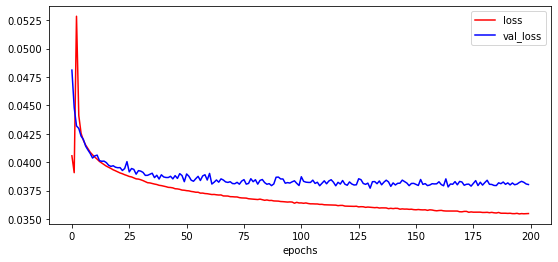

In [ ]:
loss2 = np.concatenate([loss2_1, loss2_2], axis=0)
val_loss2 = np.concatenate([vloss2_1, vloss2_2], axis=0)

AutoEncoder.plot_history([loss2, val_loss2], ['loss', 'val_loss'])

In [ ]:
z_points2 = AE2_work.encoder.predict(selected_images)
reconst_images2 = AE2_work.decoder.predict(z_points2)

txts2 = [ f'{p[0]:.3f}, {p[1]:.3f}' for p in z_points2 ]

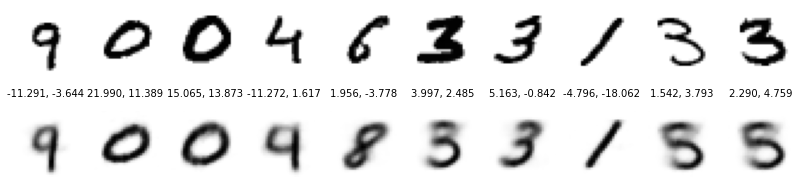

In [ ]:
%matplotlib inline

AutoEncoder.showImages(selected_images, reconst_images2, txts2, 1.4, 1.4)

# (3) Trainig with <code>tf.GradientTape()</code> function and Learning rate decay

Calculate the loss and gradients with the <code>tf.GradientTape()</code> function, and apply the gradients to the variables. 
In addition, perform Learning rate decay in the optimizer.

<font color="red">[Caution] Note that if you call the <code>save_image()</code> function in the training, <code>encoder.predict()</code> and <code>decoder.predict()</code> will work and the execution will be slow.</font>

## (3) <code>tf.GradientTape()</code> 関数と学習率減衰を使った学習

<code>tf.GradientTape()</code> 関数を使って loss と gradients を計算して、gradients を変数に適用する。
さらに、optimizer において Learning rate decay を行う。

<font color="red">(注意) trainingの途中で <code>save_images()</code>関数を呼び出すと、 <code>encoder.predict()</code>と <code>decoder.predict()</code> が動作して、実行が非常に遅くなるので注意すること。</font>

In [ ]:
save_path3 = '/content/drive/MyDrive/ColabRun/AE03/'

In [ ]:
from nw.AutoEncoder import AutoEncoder

AE3 = AutoEncoder(
    input_dim = (28, 28, 1),
    encoder_conv_filters = [32, 64, 64, 64],
    encoder_conv_kernel_size = [3, 3, 3, 3],
    encoder_conv_strides = [1, 2, 2, 1],
    decoder_conv_t_filters = [64, 64, 32, 1],
    decoder_conv_t_kernel_size = [3, 3, 3, 3],
    decoder_conv_t_strides = [1, 2, 2, 1],
    z_dim = 2
)

In [ ]:
# initial_learning_rate * decay_rate ^ (step // decay_steps)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps = 1000,
    decay_rate=0.96
)

optimizer3 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# At first, train for a few epochs.
# まず、少ない回数 training してみる

loss3_1, vloss3_1 = AE3.train(
    x_train,
    x_train,
    batch_size=32,
    epochs = 3, 
    shuffle=True,
    run_folder=save_path3,
    optimizer = optimizer3,
    save_epoch_interval=50,
    validation_data=(x_test, x_test)
    )

1/3 1875 loss: 0.0493  val loss: 0.0491  0:00:38.910057
2/3 1875 loss: 0.0451  val loss: 0.0451  0:01:17.719193
3/3 1875 loss: 0.0463  val loss: 0.0439  0:01:56.448946


In [ ]:
# Load the parameters and the weights saved before.
# 保存したパラメータと、重みを読み込む。

AE3_work = AutoEncoder.load(save_path3)
print(AE3_work.epoch)

3


In [ ]:
# Additional Training.
# 追加でtrainingする。

# Compiles the part for loss and gradients fo train_tf() function into a graph of Tensorflow 2, so it is a little over twice as fast as train(). However, it is still nearly twice as slow as fit().
# train_tf() は loss と gradients を求める部分を tf のgraphにコンパイルしているので、train()よりも2倍強高速になっている。しかし、それでもfit()よりは2倍近く遅い。

loss3_2, vloss3_2 = AE3_work.train_tf(
    x_train,
    x_train,
    batch_size=32,
    epochs = MAX_EPOCHS, 
    shuffle=True,
    run_folder= save_path3,
    optimizer = optimizer3,
    save_epoch_interval=50,
    validation_data=(x_test, x_test)
    )

4/200 1875 loss: 0.0441  val loss: 0.0432  0:00:16.470529
5/200 1875 loss: 0.0425  val loss: 0.0424  0:00:32.578862
6/200 1875 loss: 0.0418  val loss: 0.0416  0:00:48.702078
7/200 1875 loss: 0.0413  val loss: 0.0411  0:01:04.721034
8/200 1875 loss: 0.0410  val loss: 0.0408  0:01:20.828852
9/200 1875 loss: 0.0406  val loss: 0.0408  0:01:36.866276
10/200 1875 loss: 0.0403  val loss: 0.0405  0:01:52.938620
11/200 1875 loss: 0.0401  val loss: 0.0403  0:02:08.915218
12/200 1875 loss: 0.0398  val loss: 0.0403  0:02:24.993334
13/200 1875 loss: 0.0397  val loss: 0.0402  0:02:40.943671
14/200 1875 loss: 0.0395  val loss: 0.0400  0:02:57.026531
15/200 1875 loss: 0.0393  val loss: 0.0396  0:03:13.174460
16/200 1875 loss: 0.0392  val loss: 0.0397  0:03:29.264352
17/200 1875 loss: 0.0391  val loss: 0.0397  0:03:45.378318
18/200 1875 loss: 0.0389  val loss: 0.0395  0:04:01.329874
19/200 1875 loss: 0.0388  val loss: 0.0393  0:04:17.245191
20/200 1875 loss: 0.0387  val loss: 0.0394  0:04:33.400665
21/

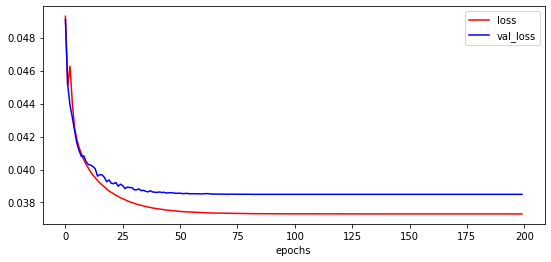

In [ ]:
loss3 = np.concatenate([loss3_1, loss3_2], axis=0)
val_loss3 = np.concatenate([vloss3_1, vloss3_2], axis=0)

AutoEncoder.plot_history([loss3, val_loss3], ['loss', 'val_loss'])

In [ ]:
z_points3 = AE3_work.encoder.predict(selected_images)
reconst_images3 = AE3_work.decoder.predict(z_points3)

txts3 = [ f'{p[0]:.3f}, {p[1]:.3f}' for p in z_points3 ]

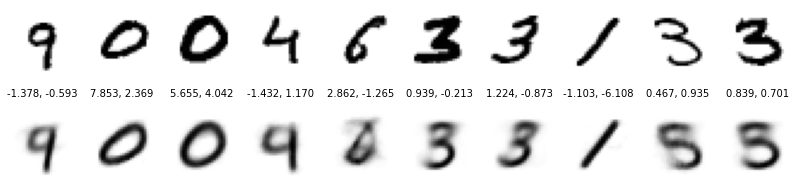

In [ ]:
%matplotlib inline

AutoEncoder.showImages(selected_images, reconst_images3, txts3, 1.4, 1.4)